# Examen Business Analytics

## TAQUET Cyril 221055

08/01/2026

Le but de l'examen va être de créer un filtre anti-spam pour les emails.

Pour ça je vais utilisé 2 modèle différent :
- un LLM avec Llama 3.2 3B
- un SVM avec un embedding

Note : ici, je ne vais que utilisé le LLM, il pourrait cependant être finetuné afin d'obtenir des résultats supérieur.

----

In [7]:
#libraries necessaires
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from transformers import AutoTokenizer, pipeline, LlamaForCausalLM
import torch
import json
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Chargement du dataset
Je supprime également le doublon et les ligne non valide c'est-à-dire avec des "NaN"

In [2]:
dataset = pd.read_csv('data/exam/data.csv') #charge le csv

dataset.dropna(inplace=True) #supprimer les lignes avec des valeurs manquantes

dataset.drop_duplicates(inplace=True) #supprime les doublons s'il y en a

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1970 entries, 0 to 1987
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  1970 non-null   object
 1   subject  1970 non-null   object
 2   date     1970 non-null   object
 3   label    1970 non-null   object
dtypes: object(4)
memory usage: 77.0+ KB


In [3]:
dataset.head()

,message,subject,date,label
0,- - - - - - - - - - - - - - - - - - - - - - fo...,transwestern capacity release report - 06 / 2000,2000-07-06,normal
1,( see attached file : hplno 428 . xls )\n- hpl...,"hpl noms for april 28 - 30 , 2001",2001-04-27,normal
2,attached is a proposed updated version of the ...,updated brm risk universe model,2000-01-27,normal
3,"louise ,\ni just received this confirmation th...",fw : issued brooklyn navy yard boiler layout,2001-07-12,normal
4,"on wednesday , june 14 th i attended your pres...","dr . kaminski ,",2000-06-16,normal


On voit que le text est anglais ce qui pourra servir à guider un peu le LLM.
### Vérification de l'équilibrage
Avant de commencer tous traitement, on va regarder à l'équilibrage du dataset. En effet, si le datset comprend trop peu d'exemple d'une classe, le modèle va être biaisé à tojours ne dire que la classe majoritaire.

In [4]:
print(Counter(dataset['label']))

Counter({'normal': 1588, 'spam': 382})


On remarque que dans notre cas, on a seulement 382 mail classifié comme spam pour 1588 mail normal. Le mails spam ne représente donc que moins de 20% du dataset complet ce qui est peu. Cependant, ceci ne deviendra un problème que lorsque qu'on entrainera le modèle. Tant qu'on fait que testé, le model n'as pas vu le email et ne sera pas biaisé par cette sur représetnation des email normaux.

###  Chargement du modèle :
Pour faire ce classement, nous allons utilise modèle LLama-3.2-3B que nous allons quantifier en INT4 afin de réduire la consomation de mémoire vidéo. Il est important de noter que passer à INT4 va réduire les capacité du modèle. Il est plus interessant de garder le modèle en INT4 et garder la place de contexte en mémoire pour pouvoir mettre l'email au complet et ne pas devoir le tronquer trop rapidement.

In [5]:
model_name = "./data/models/Llama-3.2-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = LlamaForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto",
    load_in_8bit=False,
    load_in_4bit=True,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

On va maintenant pouvoir design le prompt qui va lire et classer les emails.

In [ ]:
#fonction pour classeifier
def classify(text, model, tokenizer):
    messages = [ #prompt en anglais comme tous les mail sont en anglais même si devrait pouvoir généralise mais en moyenne c'est mieux de faire le prompt en anglais
        {
            "role": "system",
            "content": (
                "You are a SPAM filter system.\n"
                "You will receive an email text and you need to classify it as spam or normal.\n"
                "Return ONLY valid JSON.\n"
                "No explanations. No markdown.\n"
                "Format: {\"spam\": 0} or {\"spam\": 1}\n"
                "0 = email is legit\n"
                "1 = email is spam\n"
            )
        },
        {"role": "user", "content": text}
    ]


    prompt = tokenizer.apply_chat_template( #va pas le tokenizer tout de suite pour voir si tout se passe bien
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # print(prompt) #verification

    inputs = tokenizer(prompt,
                        return_tensors="pt",
                        truncation=True,
                        max_length=4096, #limite la longueur max sinon on risque juste de dépaser la capacité de la mémoire 
                        ).to(model.device) #tokenize le prompt maintenant

    # print(len(inputs['input_ids'][0])) #verification

    

    for i in range(5): #fait 5 tentaive
        outputs = model.generate(  #utilise generate à la place de pipeline car par experience peut supprimer le do_sample pour faire du greedy decoding permettant de limiter la créativité du modèle et ainsi avoir plus souvent du json en sorti et permet de relance moins souvent un generate quand foire
            **inputs,
            max_new_tokens=10, #sortie assez courte donc n'autorise pas bcp de tokens
            do_sample=False, #fait du greedy decoding ce qui devrait empecher que le model devient trop verbeux et ne resptecte plus les consignes
            eos_token_id=tokenizer.eos_token_id,
        )

        response = tokenizer.decode(outputs[0][len(inputs['input_ids'][0]):], skip_special_tokens=True) #decode càd reprend le text en anglais et pas en token, ne fait que pour les token générés et pas ceux de l'input

        try:
            return json.loads(response)['spam'], False
        except json.JSONDecodeError:
            pass
    return 0, True #si trouve pas donne classe majoritaire

In [ ]:
# parcours le dataset
y_pred = []
y_real = [0 if label == "normal" else 1 for label in dataset["label"].tolist()] #convertit en bool le normal et spam


failed = 0
for index, row in tqdm(dataset.iterrows()):
    email_text = f"SUBJECT: {row['subject']}\n\n{row['message']}" #convertit en text brut ne mets pas la date car ne me semble par important
    pred, fail = classify(email_text, model, tokenizer)
    if fail:
        failed += 1
    y_pred.append(pred) #ajoute la prédiction
print(f"Failed to classify {failed} out of {len(dataset)} emails.") #compte nombre de fail car a mis nombre maximum de tentative, sert pour voir si reste raisonable ou pas

0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
1it [00:00,  3.31it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
2it [00:00,  3.76it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
3it [00:00,  3.95it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
4it [00:01,  3.90it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
5it [00:01,  3.78it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
6it [00:01,  3.82it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
7it [00:01,  3.42it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
8it [00:02,  3.52it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
9it [00:02,  3.57it/s]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
10it [00:02,  3.72it/s]Setting `pad_token_id` to `eos_

Failed to classify 12 out of 1970 emails.


#### Après avoir calculer, on peut utiliser les métriques standard precision et recall ainsi que la matice de confusion.

On peut choisir ces métriques qui sont assez standard dans le monde de la classification.

La precision définit comme étant $\frac{\text{vrai positif}}{\text{vrai positif} + \text{faux positif}} $ donne le pourcentage de classement corrêctement effectué par le modèle. Il est donc important dans notre cas que la précision soit très éleve pour les email spam pour ne pas mêttre un email legitime à la poubelle.

Le rappel (recall en anglais) est définit comme $\frac{\text{vrai positif}}{\text{vrai positif} + \text{vrai négatif}} $ et correspond au pourcentage d'élément de la bonne classe retrouve par le model. Dans notre cas, on veut que la rappel pour les email normaux soit de 1 c'est-à-dire qu'il ne jète pas un seul email normal.

On peut également utilise le F1 score qui est une combinaison linéaire de 2 mais qui est moins utile.

La matrice de classification quant a elle montre les vrai les label vs les prédit pour voir sur quoi se trompe le model.

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1588
           1       0.54      0.95      0.69       382

    accuracy                           0.83      1970
   macro avg       0.76      0.88      0.79      1970
weighted avg       0.90      0.83      0.85      1970



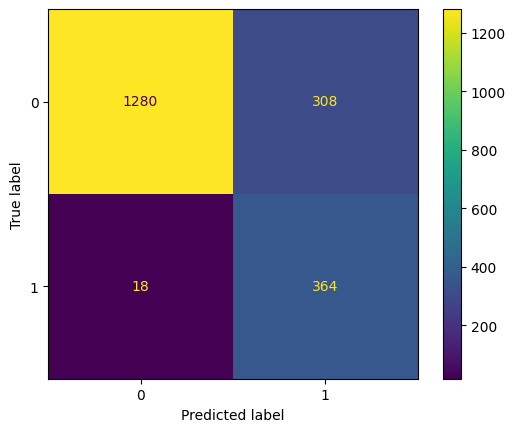

In [ ]:
print(classification_report(y_real, y_pred))
ConfusionMatrixDisplay.from_predictions(y_real, y_pred)

### Analyse des résultats

En regardant les résultats, on voit que la précision de la classe normal est parfaite, cela veut dire que le modèle est sur de lui. Cependant la métrique de rappel ne vaut que 81% montrant qu'il ne retrouve que 81% des mail normaux. Le contraire s'observe tout naturellement la classe spam ou son rappel est très elevé mais pas ça precision.

En moyenne on a une precision de 83% qui est meilleur qu'un classifieur "dummy" qui se contenterai de dire la classe majoritaire et aurai donc une précision moyenne de 80,6%.

### Analyse business

Le client peut valoir 2 chose :
- N'avoir aucun de ces mail normaux supprimé : il n'est pas professionnel de ne pas répondre a un mail à cause qu'il a été mal filtré
- N'avoir aucun spam qui passe : il a été victime de fishing ou autre attaque par mail de spam dans le passé et ne veut absolument plus que ça arrive.

Dans le cas de voir tous ces mail normaux, il faut un recall le plus parfait possible sur les email normaux et une précision élevé sur les mails spam. Ce n'est pas le cas de notre modèle ici, il ne faut pas l'utiliser dans ce cas.

Dans le second cas, ce modèle ici à une métrique de rappel de 95% sur les spam et une métrique de précision de 99% sur les normaux. Ce qui signifie que tous les mail reçu sont très certainemnet pas de spam.


Un autre problème de ce modèle et qui viens de sa nature LLM, c'est que ce genre de modèle est lent et volumineux. Il n'est donc pas facile de scale ce modèle a des taille pour une grande société avec des millier d'employé. Pour ça, il faudrait des modèles plus légé capable de tourner plus rapidement (ou d'accepter un surcout considérable en appellant des prestataire externe comme OpenAI, ...). Dans mon cas, j'ai pu traité ici 1970 email en 11 minute 30 cela fait en moyenne 2,85 email par second. Sachant que je travail par transformer et python, je peux attendre a avoir un x4 ou x5 niveau vitesse sur un vrai hosting par VLM ou llamacpp donannt environ 12 à 15 mail par second. Il faut donc déjà une grosse entreprise pour avoir besoin de traiter des mail plus rapidment que ça. 

De manière général, on voudrait trouver un modèle qui est bon dans les deux cas et est plus léger. Pour essayer un modèle plus léger, je ne vais pas finetune le LLM mais plutot utilisé un SVM avec des embeddings.

---
## Utilisation d'un SVM

On peut également utiliser une autre route pour faire cette classification sans que ça nécessite utilisation d'un LLM. 
L'idée ici est d'utiliser un model SVM ou autre classifieur simple pour décider si oui ou non c'est du spam. Ce modèle prennent en entré des nombres et pas du texte. Pour cela, il faut donc utiliser un modèle permetant de créer cette représentation. Des modèles simple comme TF-IDF existe mais depuis l'évolution de modèle transformer, il est existe le modèles dit transformer encoder qui permet de prendre du texte et de l'encoder dans un espace vectoriel. Je vais utiliser ici ce genre de modèle.

Nous avons le choix par exemple de :
- BGE-m3
- nomic embed text v1.5
- nomic embed text v2 moe

Comme ici nous allons faire un entrainement, nous avons besoin d'un split entre train et test pour ainsi avoir un ensemble pour essayer et un ensemble pour tester.

Commen mentionner avant, le dataset n'est pas équilibré. Cependant il n'est pas extraimement déequilibré dans le sens que ça reste du 1 pour 4 et pas du 1 pour 100 ou 1000 voir encore moins. Dans ce cas, pas mal de d'algorithm classique tel que les SVM peuvent encore fonctionner et ne pas demander de réequilibrer le dataset. Si on aurait moins de mail spam, il faudrait peut être utiliser des modèles comme Adaboost ou easy ensemble qui permet de mieux gérer ces cas en modifiant eux même l'ensemble utilisé.

In [3]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42) #fixe le random state pour reproductibilité

print(f"repartition normal/spam in train set: {Counter(train_data['label'])}")
print(f"repartition normal/spam in test set: {Counter(test_data['label'])}")

repartition normal/spam in train set: Counter({'normal': 1273, 'spam': 303})
repartition normal/spam in test set: Counter({'normal': 315, 'spam': 79})


Le split est valide et les proportion sont conservé. Il faut le vérifier à la main dans le cas où l'on aurait pas de chance et que ça split mal.

### Chargement modèle

utilise la library senteceTransformer car permet de faire des embedding beaucoup plus simplement

In [4]:
model_emebed = SentenceTransformer("./data/models/bge-m3", device=device)

In [5]:
x_train_text = [f"SUBJECT: {row['subject']}\n\n{row['message']}" for index, row in train_data.iterrows()] #fusion le text dans une liste car après support batching pour aller plus vite
x_test_text = [f"SUBJECT: {row['subject']}\n\n{row['message']}" for index, row in test_data.iterrows()] #pareil avec test pour plus tard

train_embeddings = model_emebed.encode(x_train_text, show_progress_bar=True, batch_size=2, convert_to_numpy=True) #ne change par l'ordre donc peut resuivre comme était dans train dataset
test_embeddings = model_emebed.encode(x_test_text, show_progress_bar=True, batch_size=2, convert_to_numpy=True) #pareil pour test

Batches:   0%|          | 0/788 [00:00<?, ?it/s]

Batches:   0%|          | 0/197 [00:00<?, ?it/s]

### Modèle SVM

J'ai utilise ici un simple SVM mais on pourrait utiliser bien différents modèles.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       315
           1       0.96      0.97      0.97        79

    accuracy                           0.99       394
   macro avg       0.98      0.98      0.98       394
weighted avg       0.99      0.99      0.99       394



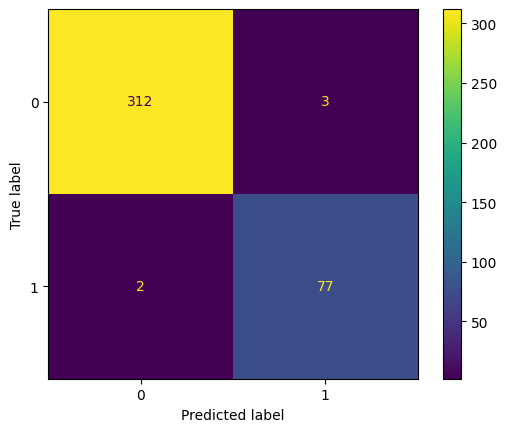

In [6]:
y_train = [0 if label == "normal" else 1 for label in train_data["label"].tolist()] #convertit en bool le normal et spam
y_test_true = [0 if label == "normal" else 1 for label in test_data["label"].tolist()] #convertit en bool le normal et spam

svm_model = SVC(C=1.5) # pas besoin de linear SVC car petit dataset

svm_model.fit(train_embeddings, y_train) #lance le train

y_pred = svm_model.predict(test_embeddings) #prédit sur le test set

# evaluation
print("Classification Report:")
print(classification_report(y_test_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test_true, y_pred)

### Analyse des performances

J'ai utilisé les même métriques que précédement afin de pouvoir comparer les modèle entre eux.

La grande différence, ici c'est que la dataset de set n'est pas tout comme au modèle précédent mais un sous ensemble comme j'ai du entainner le modèle.

On remarque ici que le modèle est proche de la perfection. On obtient un score de 99% de precision et de rappel pour la classe normal montrant qu'il est sur de de retrouver 99% des mail avec une précision de 99%. Pareil pour le spam, il la precision des de 96% et 97% de rappel ce qui est incroyable.

Comparé au modèle précédent, ce modèle le surpasse largement. 

### Analyse business
D'un point de vue business ce modèle ne fait aucun aucune concession est adapté au 2 potentiel client parlé précédememnt.

De plus, il est beaucoup plus léger. Le SVM est essentiellement instantané et l'embedding permet de traiter les 1970 mails en moins de 40s. Montrant une capacité à s'adapter à grand échelle bien supérieur au modèle LLM.


#### Remarque :
J'ai proposé 3 model d'embedding au début, j'ai remarqué des performance identique avec les autres modèles. Niveau vitesse il est difficle de les comparé étant donné que ça dépend largment de si je peux prendre 100% de la puissance du GPU ou pas. Je n'ai aussi essayé que les SVM, d'autre modèle pourrait peut être donner des résultas légèrement suppérieur mais vu de la qualité déjà trouvé, je ne pense pas que l'investissement en temps soit utile.

---

## Conclusion

Durant cette examen, j'ai du créer un system permettant de filtrer des mails basé sur un système LLM. J'ai exploré l'approche du LLM en utilisant le modèle *Llam 3.2 3B*.
Cette approche à donner des résultats interessant montrant une perfomance supérieur à juste prédire la class majoritaire mais n'était pas avait du mal à retrouver tous les mail normaux des mail de spam ce qui peut être un gros point négatif pour pas mal de client. Il avait cependant le merite de savoir absolument retrouver tous les mails de spam et ainsi garantir une protection au detriment de supprimer des mails légitime. Il est également lourd et le déployer a grande échelle semble complexe.

Le second modèle, j'ai utilisé un SVM (support vector machine) qui va juste placer la meilleur droite possible entre 2 ensemble. Pour se faire j'ai du créer un embedding du text pour avoir des vecteurs. Le modèle d'embedding impact peu le résultat. Ce modèle a donné des résultat presque parfait. Je veux dire par là qu'il retrouve quasiment tout les mail normaux avec une precision quasi parfait et de même pour le mail de type spam. Tout cela en étant plus léger et rapide que le LLM.

Cela montre qu'il vaut mieux utiliser le second modèle. 

D'un point de vue business une protection aussi parfait est très interessant permettant de fournir un service quasiment sans reproche au client.